# Overestimation of Effect Size in Low Powered Test


Low powered studies lead to overestimation of effect size. Gelman refers to this as the “winner’s curse”. Consider a low powered study with low signal and high variance. This study will on average produce statistically significant results that overestimate the true effects. 

This scenario is common when performing multiple comparison’s adjustments to p-values. The widened significance threshold requires that only results with large effect sizes are accepted. A naive perspective is to assume that because H0 is probably not true true you must accept the HA.  [refer to the study above]

Gelman’s coined the term type M error to refer to errors estimating the magnitude of effects. The risk of a low power study is then less about your success in reading a statistically significant effect but rather your probability of reading an exaggerated effect. A risk that’s arguably as detrimental as Type I or II errors. 

## Motivating Example: Credit Test

You're considering a promotion where customer's get $500 for spending $3,000 in the first 3 months of opening a credit card. The test is potentially expensive so you want to run a small test. You want to see how this promotion affects customer engagement as measured by utilization of their credit line (i.e. $ on statement / credit line).

$$
H_{0}: \mu_{a} = \mu_{b}\\
H_{a}: \mu_{a} < \mu_{b}
$$


### Calculating Sample Size

Given effect size, power, significance level (alpha)

$$
n = \left(\frac{\sigma_{p}(z_{\beta} + z_{\alpha})}{H_{s}}\right)^2
$$

If we assume equal variance and a ratio of 1:1 the pooled standard deviation equals:

$$
\sigma_{p} = 2\times\sigma
$$


In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.weightstats import ztest

In [2]:
def plot_test_design(H_0, H_s, stderr, alpha):
    plt.figure(figsize=(8,5))
    zscore_alpha = stats.norm(0, 1).ppf(1-alpha)

    # plotting function
    As = stats.norm(H_0, stderr).rvs(10000)
    Bs = stats.norm(effect, stderr).rvs(10000)

    # Shading of Type I error (alpha)
    alpha_xs = np.linspace(H_0 + stderr*zscore_alpha, np.max(As), 100)
    alpha_ymax = stats.norm(H_0, stderr).pdf(alpha_xs)
    alpha_ymin = np.zeros(alpha_xs.shape[0])

    # Shading of Type II error (1 - Beta)
    Beta_xs = np.linspace(H_0 + stderr*zscore_alpha, np.min(Bs), 100)
    Beta_ymax = stats.norm(effect, stderr).pdf(Beta_xs)
    Beta_ymin = np.zeros(Beta_xs.shape[0])

    sns.kdeplot(As, color="red", shade=False, label='Data Collected if \n HO True')
    plt.fill_between(alpha_xs, alpha_ymin, alpha_ymax, alpha=.3, color='red', label='Type I Error')
    sns.kdeplot(Bs, color="blue", shade=False, label='Data Collected if \n HS True')
    plt.fill_between(Beta_xs, Beta_ymin, Beta_ymax, alpha=.3, color='blue', label='Type II Error')

    plt.axvline(H_0 + zscore_alpha*stderr,  color='black', linestyle='--', label='Signficance Level')
    plt.legend()

### Test Inputs

**Effect Size (Substantive Hypothesis):** You would only decide to launch this promotion to the broader population if the test shows a **10% increase** in utilization

**Population Standard Deviation:** Based on prior promotions you expect the standard deviation to be **20%**

In [3]:
# Population characteristics
pop_std = 2
pooled_std = 2*pop_std
H_0 = 0

# Test Inputs
effect = .1 # minimum difference we want to be able to read
alpha = .05 # significance level (Type I Error Rate)
power = .90

zscore_alpha = stats.norm(0, 1).ppf(1-alpha)

### Test Design for Power = 90%

In [4]:
zscore_power = stats.norm(0, 1).ppf(power)
n_total_90 = ((pooled_std*(zscore_alpha + zscore_power))/effect)**2
stderr_90 = pooled_std/np.sqrt(n_total_90)
print('Standard Error: {:.1%}'.format(stderr_90))
print('Total Sample Size: {:.0f}'.format(n_total_90))

Standard Error: 3.4%
Total Sample Size: 13702


/Users/mpb798/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.3, 0.4)

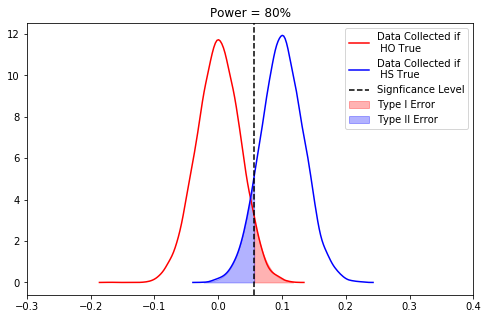

In [6]:
plot_test_design(H_0, effect, stderr_90, alpha)
plt.title('Power = 80%')
plt.xlim(-.3, .4)

In [7]:
import statsmodels.stats.power as smp
smp.tt_ind_solve_power(.1/2, alpha=.05, power=power, ratio=1.0, alternative='larger')*2

13703.508982308455

### Test Design for Power = 50%

You believe the sample size required for a power of 80% is too expensive so you consider a lower powered test

In [8]:
zscore_power = stats.norm(0, 1).ppf(.5)
n_total_50 = (pooled_std*(zscore_alpha + zscore_power)/effect)**2
stderr_50 = pooled_std/np.sqrt(n_total_50)
print('Standard Error: {:.1%}'.format(stderr_50))
print('Total Sample Size: {:.0f}'.format(n_total_50))

Standard Error: 6.1%
Total Sample Size: 4329


(-0.3, 0.4)

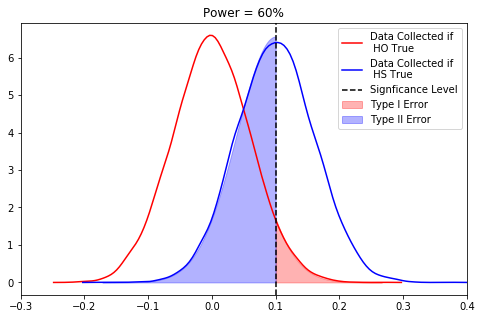

In [9]:
plot_test_design(H_0, effect, stderr_50, alpha)
plt.title('Power = 60%')
plt.xlim(-.3, .4)

## Test Power influences the observed effect size

In [10]:
iters = 1000

pvalues_50 = np.zeros(iters)
effect_size_50 = np.zeros(iters)

pvalues_90 = np.zeros(iters)
effect_size_90 = np.zeros(iters)

ses = []
for i in range(iters):
    # sample data from each test
    A_90 = stats.norm(0, pop_std).rvs(int(n_total_90/2))
    B_90 = stats.norm(effect, pop_std).rvs(int(n_total_90/2))
    
    # sample data from each test
    A_50 = stats.norm(0, pop_std).rvs(int(n_total_50/2))
    B_50 = stats.norm(effect, pop_std).rvs(int(n_total_50/2))
    
    # test
    res_50 = ztest(B_50, A_50, alternative='larger')
    res_90 = ztest(B_90, A_90, alternative='larger')
    
    se = np.sqrt((np.std(A_90)/np.sqrt(len(A_90)))**2 + (np.std(B_90)/np.sqrt(len(B_90)))**2)
    mu_diff = np.mean(B_90) - np.mean(A_90) 
    ses.append(se)
    # decision
    pvalues_90[i] = stats.norm(0,1).pdf(mu_diff/se) #res_80[1]
    effect_size_90[i] = np.mean(B_90) - np.mean(A_90)
    
    pvalues_50[i] = res_50[1]
    effect_size_50[i] = np.mean(B_50) - np.mean(A_50)

### Results for 90% Power Test

In [11]:
print('Test Power: {:.2f}'.format(np.mean(pvalues_90<=alpha)))
print('Type II Error: {:.2f}'.format(np.mean(pvalues_90>alpha)))
print('Average Significant Effect Size: {:.3f}'.format(np.mean(effect_size_90[pvalues_90<alpha])))

Test Power: 0.83
Type II Error: 0.17
Average Significant Effect Size: 0.111


### Results for 50% Power Test

In [12]:
print('Test Power: {:.2f}'.format(np.mean(pvalues_50<alpha)))
print('Type II Error: {:.2f}'.format(1 - np.mean(pvalues_50>alpha)))
print('Average Significant Effect Size: {:.3f}'.format(np.mean(effect_size_50[pvalues_50<alpha])))

Test Power: 0.49
Type II Error: 0.49
Average Significant Effect Size: 0.151


# Results

As you can see above the average efect size that we find signficant under a 90% Power test is 11.1% and 15% under a 50% test. Under the lower powered test you are far more likely to overstate the effect of your treatment!